<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/Optimizer_HP_tuning_Clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [7]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train,y_train,10)
  return score

In [9]:
variance = np.linspace(0.5,1.5,6)
lengthscale = np.linspace(0.5,1.5,6)
x1,x2=np.meshgrid(variance,lengthscale)

In [26]:
def BO(var,l,clf):
  kernel = GPy.kern.Matern52(input_dim=1, variance=var, lengthscale=l)
  optimizer = GPyOpt.methods.BayesianOptimization(f=clf, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X)+(0.01^2)*np.identity(25))),(optimizer.Y - m)) \
          -0.5 * np.log(np.linalg.det(kernel.K(X)+(0.01^2)*np.identity(25))) - np.pi * 0.5 * np.log(2*np.pi)
  return log_mll

In [11]:
score_rf=[]
for i in range(len(variance)):
  for j in range(len(lengthscale)):
    acc = BO(variance[i],lengthscale[j],rf_score)
    score_rf.append(acc)

In [16]:
y=x1*x2
score_rf=np.reshape(score_rf,y.shape)

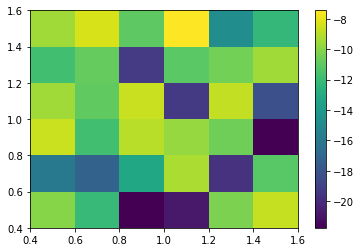

In [18]:
fig, ax = plt.subplots()
plot1 = ax.pcolormesh(x1, x2, score_rf)
fig.colorbar(plot1, ax=ax)

In [19]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.001, 1)}
      ]

def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [20]:
score_SVM=[]
for i in range(len(variance)):
  for j in range(len(lengthscale)):
    acc = BO(variance[i],lengthscale[j],svm_score)
    score_SVM.append(acc)

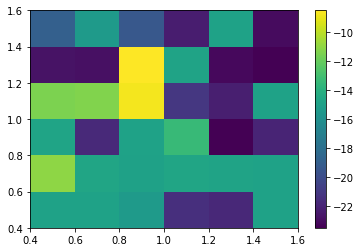

In [21]:
score_SVM=np.reshape(score_SVM,y.shape)
fig, ax = plt.subplots()
plot2 = ax.pcolormesh(x1, x2, score_SVM)
fig.colorbar(plot2, ax=ax)

In [23]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]

def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [24]:
score_KNN=[]
for i in range(len(variance)):
  for j in range(len(lengthscale)):
    acc = BO(variance[i],lengthscale[j],knn_score)
    score_KNN.append(acc)

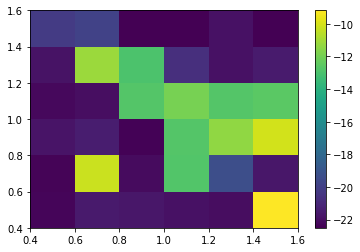

In [25]:
score_KNN=np.reshape(score_KNN,y.shape)
fig, ax = plt.subplots()
plot3 = ax.pcolormesh(x1, x2, score_KNN)
fig.colorbar(plot3, ax=ax)